### Haonan Xu
### FinTech 545 - Week 2 Homework

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

### Problem 1

#### (a)

In [2]:
# import problem1.csv
df = pd.read_csv("problem1.csv")
x_data = df.to_numpy().flatten()

# a. 
# calculate first 4 moments using normalized formula

def first4Moments(sample):

    n = len(sample)
    # mean
    mu_hat = sum(sample)/n

    # remove the mean from the sample
    sim_corrected = sample - mu_hat
    
    # variance (not bias adjusted)
    sigma_2 = sum(sim_corrected * sim_corrected) / n

    # sample variance
    # sigma_2_hat = sum(sim_corrected * sim_corrected) / (n-1)

    # skewness
    skew_hat = sum(sim_corrected ** 3) / n / np.sqrt(sigma_2 ** 3)

    # kurtosis
    kurt_hat = sum(sim_corrected ** 4) / n / np.sqrt(sigma_2 ** 4)

    excess_kurt_hat = kurt_hat - 3
    
    return mu_hat, sigma_2, skew_hat, excess_kurt_hat

# first 4 moments of x data
mu, sigma_2, skew, kurt = first4Moments(x_data)

#### (b)

In [3]:
# b.
# calculate first 4 moments by statistical package
mu_stat = np.mean(x_data)
sigma_2_stat = np.var(x_data)
skew_stat = stats.skew(x_data)
kurt_stat = stats.kurtosis(x_data)

# print the measures to compare
pd.DataFrame(data = {
    "Method": ["Formula", "Package", "Difference"],
    "mena": [mu, mu_stat, mu - mu_stat],
    "variance": [sigma_2, sigma_2_stat, sigma_2 - sigma_2_stat],
    "skewness": [skew, skew_stat, skew - skew_stat],
    "kurtosis": [kurt, kurt_stat, kurt - kurt_stat]
})

,Method,mena,variance,skewness,kurtosis
0,Formula,1.048970e+00,5.421793e+00,8.806086e-01,2.312220e+01
1,Package,1.048970e+00,5.421793e+00,8.806086e-01,2.312220e+01
2,Difference,-2.220446e-16,-1.776357e-15,1.221245e-15,-3.552714e-15


#### (c)

In [4]:
# c. 
# test 

# number of trials
samples = 1000
# sample size
n = 100
# empty array to hold estimate samples
mu = []
sigma_2 = []
skew = []
kurt = []
# simulation
for i in range(samples):
    data = np.random.normal(0, 1, n)
    mu.append(np.mean(data))
    sigma_2.append(np.var(data))
    skew.append(stats.skew(data))
    kurt.append(stats.kurtosis(data))
    
# t-test function against theoretical value
def ttest(est, est0):
    t = (np.mean(est) - est0) / np.sqrt(np.var(est)/len(est))
    p = 2 * (1 - stats.t.cdf(np.abs(t), len(est)-1))
    
    return t,p

t_mu, p_mu = ttest(mu, 0)
t_sigma, p_sigma = ttest(sigma_2, 1)
t_skew, p_skew = ttest(skew, 0)
t_kurt, p_kurt = ttest(kurt, 0)

pd.DataFrame(data = {
    " ": ["unbiased estimate", "t stat", "p-value"],
    "mean": [0, t_mu, p_mu],
    "variance": [1, t_sigma, p_sigma],
    "skewness": [0, t_skew, p_skew],
    "kurtosis": [0, t_kurt, p_kurt]
})


,,mean,variance,skewness,kurtosis
0,unbiased estimate,0.000000,1.000000,0.000000,0.000000
1,t stat,1.705556,-3.056501,-1.003092,-3.134240
2,p-value,0.088402,0.002299,0.316059,0.001773


### Problem 2

#### (a)

In [5]:
# import problem2.csv
# use LinearRegression()
df = pd.read_csv("problem2.csv")
X = df["x"].to_numpy()
X = np.column_stack((np.ones(len(X)), X))

Y = df["y"].to_numpy().flatten()
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     104.6
Date:                Fri, 26 Jan 2024   Prob (F-statistic):           5.59e-20
Time:                        12:02:55   Log-Likelihood:                -284.54
No. Observations:                 200   AIC:                             573.1
Df Residuals:                     198   BIC:                             579.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0874      0.071     -1.222      0.2

0.3456068835648127

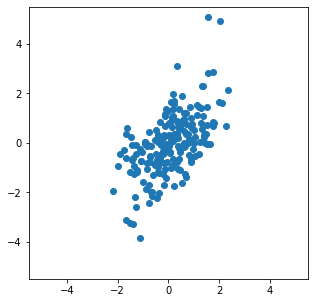

In [6]:
X1 = df["x"].to_numpy()
plt.figure(figsize = (5,5))
plt.scatter(X1, Y)
plt.xlim(-5.5,5.5)
plt.ylim(-5.5,5.5)

# correlation
cor = np.corrcoef([X1,Y], rowvar=True)
cor[1,0] ** 2

In [7]:
# a.
# Fit the data using OLS.
# beta_ols = np.linalg.inv(X.T @ X) @ X.T @ Y
model = sm.OLS(Y, X).fit()
beta_ols = model.params
print(model.summary())
print("OLS Beta:  ", beta_ols)

# epsilon = Y - X @ beta_ols
epsilon = model.resid
sigma_ols = np.std(epsilon)
print("OLS Sigma: ", sigma_ols)

# Fit the data using MLE
# define likelihood function under normality assumption
def ll_n(params):
    s = params[0]
    b = params[1:]
    n = len(Y)
    e = Y - np.dot(X, b)
    s2 = s * s
    # log likelihood of n
    ll = -n / 2 * np.log(s2 * 2 * np.pi) - np.dot(e, e) / (2 * s2)
    return -ll  # return negative ll because we minimize

res = minimize(ll_n, [1,0,0], options={"disp": True})
sigma_mle, *beta_mle = res.x
print("MLE Beta:  ", beta_mle)
print("MLE Sigma: ", sigma_mle)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     104.6
Date:                Fri, 26 Jan 2024   Prob (F-statistic):           5.59e-20
Time:                        12:02:55   Log-Likelihood:                -284.54
No. Observations:                 200   AIC:                             573.1
Df Residuals:                     198   BIC:                             579.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0874      0.071     -1.222      0.2

In [8]:
# adjusted R^2 for normal
def adj_R2(beta_mle):
    rr = Y - np.dot(X, beta_mle)
    SSR = np.dot(rr, rr)
    tt = Y - np.mean(Y)
    SST = np.dot(tt, tt)
    R_square = 1 - SSR / SST

    n = len(Y)
    p = 1
    R_square_adj = 1 - ((1 - R_square)*(n-1)/(n-p-1))
    
    return R_square_adj

print("Adjusted R^2:", adj_R2(beta_mle))

Adjusted R^2: 0.3423018678252412


#### (b)

In [9]:
# b.
# define likelihood function under T assumption
def ll_t(params):
    df = params[0]
    s = params[1]
    b = params[2:]
    e = Y - np.dot(X, b)
    # log likelihood of t: sum of pdf under t distribution
    ll = np.sum(stats.t.logpdf(e, df=df, loc=0, scale=s))
    # ll = np.sum(stats.t.logpdf(e, df=df))
    return -ll # return negative ll because we minimize

res = minimize(ll_t, [1,1,0,0], options={"disp": True})
df_mle, sigma_mle, *beta_mle = res.x
# print("MLE DF:    ", df_mle)
print("MLE Beta:  ", beta_mle)
print("MLE Sigma: ", sigma_mle)

Optimization terminated successfully.
         Current function value: 281.293403
         Iterations: 19
         Function evaluations: 115
         Gradient evaluations: 23
MLE Beta:   [-0.0972694218123758, 0.6750091062888176]
MLE Sigma:  0.8551037051346911


In [10]:
# adjusted R^2 for T
print("Adjusted R^2:", adj_R2(beta_mle))

Adjusted R^2: 0.33631962144512395


#### (c)

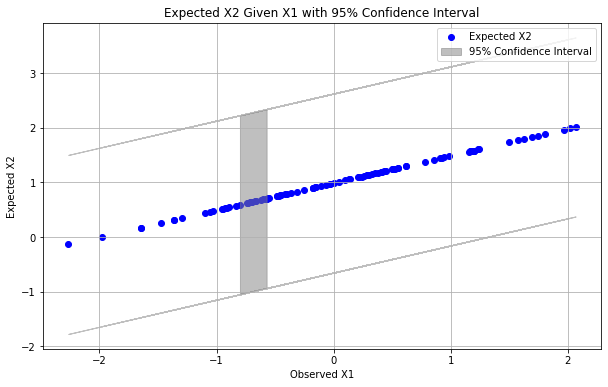

In [11]:
# c.
# import problem2_x.csv and problem2_x1.csv
df_x = pd.read_csv("problem2_x.csv")
# full [X_1, X_2]
X = df_x.to_numpy()

df_x1 = pd.read_csv("problem2_x1.csv")
# observed X_1
X1_obs = df_x1.to_numpy()

# mean of X
mu = np.mean(X, axis=0)
# covariance of X
cov = np.cov(X, rowvar=False)

# Conditional distribution of X2 given X1
# Extract mean and covariance for each dimension
mu_1, mu_2 = mu
cov_11, cov_12, cov_21, cov_22 = cov.flatten()

# Calculate conditional means and variances for X2 given observed X1
conditional_means = mu_2 + cov_21 / cov_11 * (X1_obs - mu_1)
conditional_variances = cov_22 - cov_21**2 / cov_11

# Calculate 95% confidence intervals
ci_95 = 1.96 * np.sqrt(conditional_variances)

plot_data = pd.DataFrame({
    'X1_observed': X1_obs.flatten(),
    'Expected_X2': conditional_means.flatten(),
    'Lower_CI': conditional_means.flatten() - ci_95,
    'Upper_CI': conditional_means.flatten() + ci_95
})

# Plot the expected value of X2 along with the 95% confidence interval
plt.figure(figsize=(10, 6))
plt.scatter(plot_data['X1_observed'], plot_data['Expected_X2'], color='blue', label='Expected X2')
plt.fill_between(plot_data['X1_observed'], plot_data['Lower_CI'], plot_data['Upper_CI'], color='gray', alpha=0.5, label='95% Confidence Interval')
plt.xlabel('Observed X1')
plt.ylabel('Expected X2')
plt.title('Expected X2 Given X1 with 95% Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()

### Problem 3

In [12]:
# import problem3.csv
df = pd.read_csv("problem3.csv")
X = df["x"].to_numpy().flatten()

# AR(1)
model = ARIMA(X, order=(1, 0, 0))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -819.328
Date:                Fri, 26 Jan 2024   AIC                           1644.656
Time:                        12:02:57   BIC                           1657.299
Sample:                             0   HQIC                          1649.617
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1258      0.070     30.473      0.000       1.989       2.263
ar.L1          0.2019      0.045      4.512      0.000       0.114       0.290
sigma2         1.5517      0.105     14.743      0.0

In [13]:
# AR(2)
model = ARIMA(X, order=(2, 0, 0))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -786.540
Date:                Fri, 26 Jan 2024   AIC                           1581.079
Time:                        12:02:57   BIC                           1597.938
Sample:                             0   HQIC                          1587.694
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1270      0.049     43.663      0.000       2.032       2.222
ar.L1          0.2732      0.042      6.486      0.000       0.191       0.356
ar.L2         -0.3505      0.043     -8.068      0.0

In [14]:
# AR(3)
model = ARIMA(X, order=(3, 0, 0))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -713.330
Date:                Fri, 26 Jan 2024   AIC                           1436.660
Time:                        12:02:57   BIC                           1457.733
Sample:                             0   HQIC                          1444.929
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1209      0.085     24.990      0.000       1.955       2.287
ar.L1          0.4515      0.040     11.179      0.000       0.372       0.531
ar.L2         -0.4887      0.037    -13.104      0.0

In [15]:
# MA(1)
model = ARIMA(X, order=(0, 0, 1))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -780.702
Date:                Fri, 26 Jan 2024   AIC                           1567.404
Time:                        12:02:57   BIC                           1580.047
Sample:                             0   HQIC                          1572.365
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1236      0.085     25.028      0.000       1.957       2.290
ma.L1          0.6434      0.034     18.847      0.000       0.577       0.710
sigma2         1.3282      0.090     14.782      0.0

In [16]:
# MA(2)
model = ARIMA(X, order=(0, 0, 2))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -764.971
Date:                Fri, 26 Jan 2024   AIC                           1537.941
Time:                        12:02:57   BIC                           1554.800
Sample:                             0   HQIC                          1544.556
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1255      0.060     35.199      0.000       2.007       2.244
ma.L1          0.4344      0.044      9.775      0.000       0.347       0.522
ma.L2         -0.2306      0.047     -4.949      0.0

In [17]:
# MA(3)
model = ARIMA(X, order=(0, 0, 3))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(0, 0, 3)   Log Likelihood                -763.434
Date:                Fri, 26 Jan 2024   AIC                           1536.868
Time:                        12:02:57   BIC                           1557.941
Sample:                             0   HQIC                          1545.137
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1259      0.059     35.880      0.000       2.010       2.242
ma.L1          0.5582      0.045     12.333      0.000       0.469       0.647
ma.L2         -0.2286      0.053     -4.308      0.0